# Model Training

Model comparison (XGBoost, RandomForest, Ridge, etc.) with RMSE evaluation. 

To be added from national-news.ipynb soon!

In [2]:
# Generalised Topic Model Training Script

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def train_topic_model(input_file: str, feature_prefix: str, model_save_path: str):
    # Load data
    df = pd.read_csv(input_file)

    # Preview
    cols = ['month', 'INDPRO', 'sentiment'] + [c for c in df.columns if c not in ('month', 'INDPRO', 'sentiment')]
    display(df[cols].head())

    # Define models and hyperparameters
    models_and_params = {
        'XGBoost': {
            'model': XGBRegressor(objective='reg:squarederror', random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0]
            }
        },
        'LightGBM': {
            'model': LGBMRegressor(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'num_leaves': [31, 50]
            }
        },
        'CatBoost': {
            'model': CatBoostRegressor(verbose=0, random_state=42),
            'params': {
                'iterations': [100, 300],
                'learning_rate': [0.01, 0.1],
                'depth': [3, 5]
            }
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10],
                'min_samples_split': [2, 5]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'max_depth': [None, 10]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0]
            }
        },
        'Lasso': {
            'model': Lasso(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0]
            }
        },
        'ElasticNet': {
            'model': ElasticNet(random_state=42),
            'params': {
                'alpha': [0.01, 0.1, 1.0],
                'l1_ratio': [0.2, 0.5, 0.8]
            }
        },
        'BayesianRidge': {
            'model': BayesianRidge(),
            'params': {}
        },
        'SVR-RBF': {
            'model': SVR(kernel='rbf'),
            'params': {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto']
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 10],
                'weights': ['uniform', 'distance']
            }
        },
        'MLP': {
            'model': MLPRegressor(random_state=42, max_iter=500),
            'params': {
                'hidden_layer_sizes': [(50,), (100,)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001]
            }
        }
    }

    # Select features and target
    features = [col for col in df.columns if col.startswith(feature_prefix) or col.startswith('publication_')]
    features.append('sentiment')
    X = df[features]
    y = df['INDPRO']

    # Train-test split
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)
    best_models = []

    for name, mp in models_and_params.items():
        print(f"\n🔍 Tuning {name}...")
        grid = GridSearchCV(
            estimator=mp['model'],
            param_grid=mp['params'],
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            verbose=0
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        best_models.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Test RMSE': rmse
        })

    results_df = pd.DataFrame(best_models).sort_values(by='Test RMSE')
    print(results_df)

    # Get the best model
    best_idx = results_df['Test RMSE'].idxmin()
    best_name = results_df.loc[best_idx, 'Model']
    best_params = results_df.loc[best_idx, 'Best Params']

    # Final model instantiation and training
    if best_name == 'XGBoost':
        final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
    elif best_name == 'RandomForest':
        final_model = RandomForestRegressor(random_state=42, **best_params)
    elif best_name == 'GradientBoosting':
        final_model = GradientBoostingRegressor(random_state=42, **best_params)
    elif best_name == 'Ridge':
        final_model = Ridge(**best_params)
    elif best_name == 'ExtraTrees':
        final_model = ExtraTreesRegressor(random_state=42, **best_params)
    elif best_name == 'BayesianRidge':
        final_model = BayesianRidge(**best_params)
    elif best_name == 'Lasso':
        final_model = Lasso(random_state=42, **best_params)
    elif best_name == 'CatBoost':
        final_model = CatBoostRegressor(verbose=0, random_state=42, **best_params)
    elif best_name == "KNN":
        final_model = KNeighborsRegressor(**best_params)
    elif best_name == "SVR-RBF":
        final_model = SVR(**best_params)
    else:
        raise ValueError(f"Unknown model: {best_name}")

    final_model.fit(X_train, y_train)
    joblib.dump(final_model, model_save_path)
    print(f"✅ Saved best model ({best_name}) to {model_save_path}")

    # Plot results
    results_df.plot(x='Model', y='Test RMSE', kind='barh', legend=False, title='Model Comparison (Test RMSE)')
    plt.xlabel("RMSE (Lower is Better)")
    plt.tight_layout()
    plt.show()

    # Predict with final model on full dataset (train & test)
    y_all_pred = final_model.predict(X)
    # Add predictions to the dataframe
    df["IPI_predicted"] = y_all_pred
    
    return df, results_df


,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.332366,0.047303,0.108757,0.065400,0.177487,0.078956,0.089427,0.147791,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.359760,0.048579,0.034060,0.039285,0.080410,0.048981,0.047445,0.082206,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.453634,0.076843,0.100812,0.062806,0.020819,0.084967,0.164064,0.143699,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.449364,0.178754,0.065679,0.069355,0.092416,0.028589,0.146400,0.133294,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.171123,0.027663,0.115164,0.163197,0.309055,0.035086,0.034965,0.189210,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

               Model                                        Best Params  \
4         ExtraTrees           {'max_depth': None, 'n_estimators': 100}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
7              Lasso                                    {'alpha': 0.01}   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 300, 'n...   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
12               MLP  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...   
9      BayesianRidge                                                 {}   
11               KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
6              Ridge                                     {'alpha': 0.1}   
10           SVR-RBF     

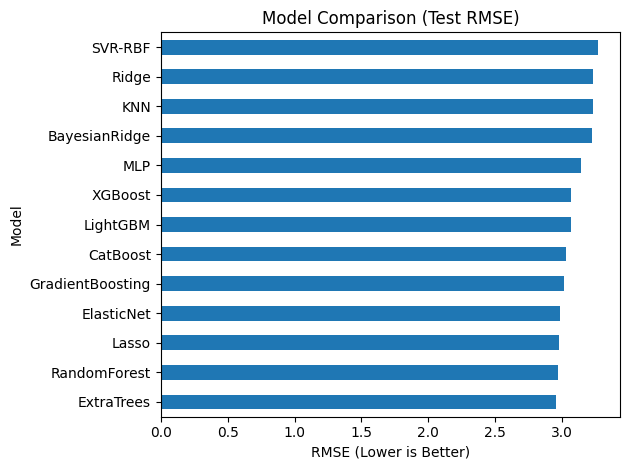

In [4]:
df_with_preds, model_comparison = train_topic_model(
    input_file="../data/processed/features_lda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/best_model_lda.joblib"
)
# Save predictions to CSV 
df_with_preds.to_csv("../data/processed/lda_with_ipi_preds.csv", index=False)

,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.332366,0.096154,0.192308,0.153846,0.019231,0.134615,0.250000,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.359760,0.016807,0.042017,0.134454,0.050420,0.058824,0.588235,0.008403,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.453634,0.100000,0.050000,0.016667,0.411111,0.266667,0.027778,0.016667,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.449364,0.061674,0.154185,0.074890,0.061674,0.273128,0.189427,0.008811,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.171123,0.036145,0.328313,0.307229,0.006024,0.015060,0.021084,0.000000,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JarckJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

               Model                                        Best Params  \
7              Lasso                                    {'alpha': 0.01}   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 300, 'n...   
11               KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
12               MLP  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...   
9      BayesianRidge                                                 {}   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
10           SVR-RBF                        {'C': 10, 'gamma': 'scale'}   
6              Ridge     

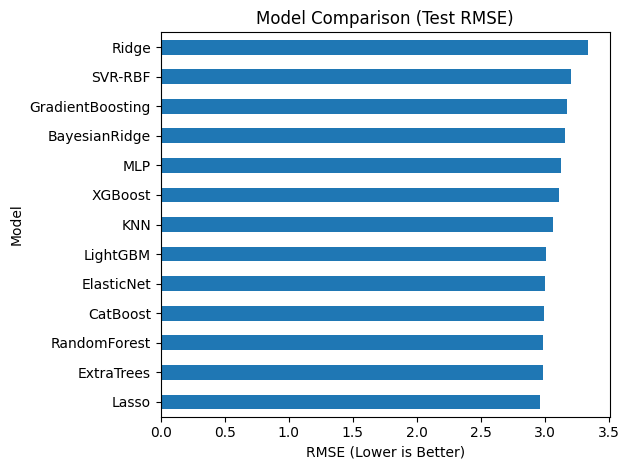

In [5]:
df_with_preds, model_comparison = train_topic_model(
    input_file="../data/processed/features_bertopic_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/best_model_bertopic.joblib"
)
# Save predictions to CSV 
df_with_preds.to_csv("../data/processed/bertopic_with_ipi_preds.csv", index=False)

,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

               Model                                        Best Params  \
9      BayesianRidge                                                 {}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...   
7              Lasso                                    {'alpha': 0.01}   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
6              Ridge                                     {'alpha': 0.1}   
10           SVR-RBF                        {'C': 10, 'gamma': 'scale'}   
11               KNN           {'n_neighbors': 5, 'weights': 'uniform'}   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 100, 'n...   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
12               MLP  {'a

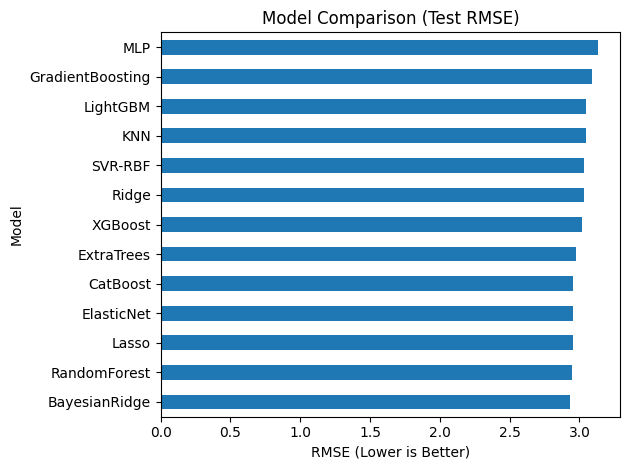

,Model,Best Params,Test RMSE
9,BayesianRidge,{},2.932180
3,RandomForest,"{'max_depth': None, 'min_samples_split': 5, 'n...",2.945889
7,Lasso,{'alpha': 0.01},2.950239
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",2.950306
2,CatBoost,"{'depth': 5, 'iterations': 300, 'learning_rate...",2.952817
4,ExtraTrees,"{'max_depth': None, 'n_estimators': 300}",2.975242
0,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",3.021482
6,Ridge,{'alpha': 0.1},3.030016
10,SVR-RBF,"{'C': 10, 'gamma': 'scale'}",3.032897
11,KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",3.044329


In [8]:
df_with_preds, model_comparison = train_topic_model(
    input_file="../data/processed/features_slda_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/best_model_slda.joblib"
)
# Save predictions to CSV 
df_with_preds.to_csv("../data/processed/slda_with_ipi_preds.csv", index=False)

,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_Mashable,publication_New Republic,publication_New Yorker,publication_Politico,publication_Reuters,publication_The Hill,publication_The Verge,publication_Vice News,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.359760,0.282868,0.303174,0.055365,0.184831,0.314040,0.278684,0.204099,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.453634,0.335409,0.275612,0.085674,0.257200,0.190609,0.399465,0.330665,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.449364,0.292521,0.237691,0.103655,0.168196,0.191956,0.222145,0.195695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.171123,0.143012,0.271206,0.045638,0.173059,0.269370,0.137411,0.142544,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.297804,0.136806,0.257614,0.011366,0.254939,0.203234,0.128820,0.170342,...,False,False,False,False,False,False,False,False,False,False



🔍 Tuning XGBoost...

🔍 Tuning LightGBM...

🔍 Tuning CatBoost...

🔍 Tuning RandomForest...

🔍 Tuning ExtraTrees...

🔍 Tuning GradientBoosting...

🔍 Tuning Ridge...

🔍 Tuning Lasso...

🔍 Tuning ElasticNet...

🔍 Tuning BayesianRidge...

🔍 Tuning SVR-RBF...

🔍 Tuning KNN...

🔍 Tuning MLP...


/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rada/Documents/GitHub/project-ds4pp-eth2025/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

               Model                                        Best Params  \
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 100}   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
7              Lasso                                    {'alpha': 0.01}   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
3       RandomForest  {'max_depth': None, 'min_samples_split': 2, 'n...   
11               KNN           {'n_neighbors': 3, 'weights': 'uniform'}   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 100, 'n...   
9      BayesianRidge                                                 {}   
6              Ridge                                     {'alpha': 0.1}   
10           SVR-RBF                        {'C': 10, 'gamma': 'scale'}   
12               MLP  {'a

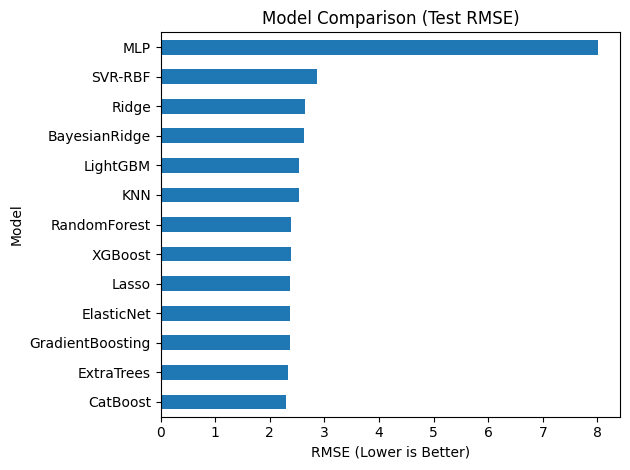

,Model,Best Params,Test RMSE
2,CatBoost,"{'depth': 5, 'iterations': 300, 'learning_rate...",2.288463
4,ExtraTrees,"{'max_depth': None, 'n_estimators': 100}",2.341293
5,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2.363938
8,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.2}",2.374942
7,Lasso,{'alpha': 0.01},2.376658
0,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2.386256
3,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n...",2.388342
11,KNN,"{'n_neighbors': 3, 'weights': 'uniform'}",2.539037
1,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",2.540958
9,BayesianRidge,{},2.633006


In [11]:
df_with_preds, model_comparison = train_topic_model(
    input_file="../data/processed/features_minillm_monthly.csv",
    feature_prefix="topic_",
    model_save_path="../models/best_model_minillm.joblib"
)
# Save predictions to CSV 
df_with_preds.to_csv("../data/processed/minillm_with_ipi_preds.csv", index=False)